In [4]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

input_mzml_files = glob.glob('results/interim/*.mzML')

raw_data=[]
for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    raw_data.append(exp)

ref_index = [i[0] for i in sorted(enumerate([exp.size() for exp in raw_data]), key=lambda x:x[1])][-1]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", 3000)
aligner.setParameters(aligner_par)
aligner.setReference(raw_data[ref_index])

for exp in raw_data[:ref_index] + raw_data[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(exp, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(exp, trafo, True)

for exp in raw_data:    
    mzml_file = os.path.join("results", "", "FFMI", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[19:-5] +".mzML")
    MzMLFile().store(mzml_file, exp)

In [5]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [ ]:
input_mzml_files=glob.glob("results/FFMI/interim/*.mzML")
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('epemicins.tsv')

    # FeatureMap to store results
    fm = FeatureMap()

    # edit some parameters
    #reduce RT window (way lower window if process) + peak width
    #process all raw data with Alignment etc - do not overwrite them
    #plot them to see the quality of peaks
    params = ff.getParameters()
    #params[b'debug']= 3
    params[b'extract:mz_window'] = 5.0 
    #params[b'model:type']= b'none'
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)

    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm)

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "FFMI", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

In [32]:
input_feature_files = glob.glob('results/FFMI/interim/*.featureXML')

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "FFMI", "", 'features_' + os.path.basename(filename)[:-10] +"csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)

FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
9919737473830380311,2,415.803619,712.418457,409.503357,422.053711,feature_7053_m1422.822388_z2_rt411.248444,1.16475,10293880.0
16557224813596914188,2,390.900848,712.418762,378.459991,400.481689,feature_120_m1422.822998_z2_rt389.881348,1.16475,43539808.0
11431217957564568839,1,406.720306,1423.830811,400.236481,408.808289,feature_3016_m1422.823486_z1_rt401.256958,1.16475,132491.5


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
3940019556314067903,2,405.391022,712.418823,388.789673,416.644165,feature_123_m1422.82312_z2_rt399.842987,1.16475,24336220.0
4245987954515277983,1,405.244080,1423.830811,395.194519,416.106201,feature_3016_m1422.823486_z1_rt401.256958,1.16475,1691397.0


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
17157070153405160316,2,415.16745,712.418457,407.151581,423.272583,feature_7053_m1422.822388_z2_rt411.248444,1.16475,26517.269531


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
3326756843067845341,2,390.871155,712.418762,381.062561,395.353088,feature_120_m1422.822998_z2_rt389.881348,1.16475,28654040.0
1799599250566381433,2,405.469147,712.418823,395.353088,419.141113,feature_123_m1422.82312_z2_rt399.842987,1.16475,273855616.0
17773167733824384801,1,405.439972,1423.830811,394.049988,417.391571,feature_3016_m1422.823486_z1_rt401.256958,1.16475,34801740.0


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
6930590756233431686,2,405.705475,712.418457,393.497406,417.130310,feature_7053_m1422.822388_z2_rt411.248444,1.16475,3.501041e+07
11982972146869446367,2,391.142059,712.418762,388.044525,393.497406,feature_120_m1422.822998_z2_rt389.881348,1.16475,5.495314e+05
7563536664440622983,1,405.661804,1423.830811,396.006561,415.818115,feature_3016_m1422.823486_z1_rt401.256958,1.16475,2.151945e+06


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
10614507679258273475,2,415.572937,712.418457,410.113617,420.982147,feature_7053_m1422.822388_z2_rt411.248444,1.164750,1.589046e+07
16193190596340554002,2,391.021667,712.418762,378.817352,398.759491,feature_120_m1422.822998_z2_rt389.881348,5.265967,6.131118e+07
7333509365268266037,2,405.907684,712.418823,400.558411,410.113617,feature_123_m1422.82312_z2_rt399.842987,1.164750,1.001551e+07
2086235050417367199,1,405.952301,1423.830811,398.331207,409.617584,feature_3016_m1422.823486_z1_rt401.256958,1.164750,6.245656e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
7050995736005146245,2,406.563599,712.418457,399.882935,412.146698,feature_7053_m1422.822388_z2_rt411.248444,1.16475,30328620.0
558595605080884760,2,390.806000,712.418762,378.998566,399.285156,feature_120_m1422.822998_z2_rt389.881348,1.16475,72398608.0
359763923367143714,1,406.106598,1423.830811,396.913269,411.999268,feature_3016_m1422.823486_z1_rt401.256958,1.16475,2731575.0


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
3301799801282876062,2,390.975372,712.418762,387.124939,393.363678,feature_120_m1422.822998_z2_rt389.881348,1.16475,4.843398e+05
4342391983593890475,2,405.336090,712.418823,393.363678,416.870819,feature_123_m1422.82312_z2_rt399.842987,1.16475,2.500528e+07
15111871877976796160,1,405.295135,1423.830811,395.231628,415.599854,feature_3016_m1422.823486_z1_rt401.256958,1.16475,1.644101e+06


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
4806411645106266683,2,390.791138,712.418762,385.324341,393.196503,feature_120_m1422.822998_z2_rt389.881348,2.435265,1111529.0
8640654149145325635,2,404.847534,712.418823,393.196503,421.608459,feature_123_m1422.82312_z2_rt399.842987,1.164750,33022230.0
15370980805248308178,1,404.783936,1423.830811,394.739044,419.922485,feature_3016_m1422.823486_z1_rt401.256958,3.061373,2109357.0


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
9687234404832969787,2,391.089569,712.418762,380.055664,396.595551,feature_120_m1422.822998_z2_rt389.881348,1.16475,7146565.0
14946888384960977515,2,405.372559,712.418823,396.595551,418.994110,feature_123_m1422.82312_z2_rt399.842987,1.16475,48611672.0
1263019521581183172,1,405.218872,1423.830811,395.277924,418.031189,feature_3016_m1422.823486_z1_rt401.256958,1.16475,4146058.0


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
14651107251476267057,2,407.173401,712.418457,399.099121,421.370605,feature_7053_m1422.822388_z2_rt411.248444,1.16475,40886.371094


In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

filename = 'results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML'

def plotDetectedFeatures3D(path_to_featureXML):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(path_to_featureXML, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()


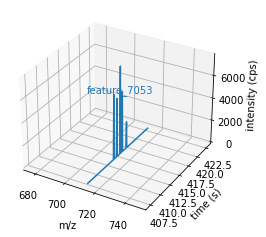

In [20]:
plotDetectedFeatures3D(filename)